In [1]:
import os
import numpy as np
import pandas as pd
import pymatreader as pymat
from sklearn.svm import SVC
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

In [2]:
path_str = os.getcwd() + '/'

In [5]:
data_file_name = 'Majazi1.mat'
gt_file_name = 'Majazi1_gt.mat'

In [7]:
data = pymat.read_mat(path_str + data_file_name)['Botswana']
data_gt = pymat.read_mat(path_str + gt_file_name)['Botswana_gt']

In [8]:
print(f'\nShape of Data: {data.shape}\n')
print(f'\nShape of GT: {data_gt.shape}\n')


Shape of Data: (1476, 256, 145)


Shape of GT: (1476, 256)



In [9]:
def BG_removal(data_3D: np.ndarray, data_gt_2D: np.ndarray) -> (np.ndarray, np.ndarray):
    data_copy = data_3D.copy()
    gt_copy = data_gt_2D.copy()
    
    data_reshaped = data_copy.reshape((data_copy.shape[0] * data_copy.shape[1], data_copy.shape[2]))
    gt_reshaped = gt_copy.ravel()
    classes_unique = np.unique(gt_reshaped)
    new_data = data_reshaped[gt_reshaped != 0]
    new_gt = gt_reshaped[gt_reshaped != 0]
    
    return new_data, new_gt

In [10]:
data_without_BG, gt_without_BG = BG_removal(data_3D=data, data_gt_2D=data_gt)

In [11]:
print(f'\nShape of the BG_removed Data: {colored(data_without_BG.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(data_without_BG.dtype, "green")}\n\n')
print(f'\nShape of the BG_removed GT: {colored(gt_without_BG.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(gt_without_BG.dtype, "green")}\n')


Shape of the BG_removed Data: (3248, 145)

 ... and its Data Type: uint16



Shape of the BG_removed GT: (3248,)

 ... and its Data Type: uint8



In [12]:
def class_separator(X: np.ndarray, y: np.ndarray) -> dict:
    
    unique_labels = np.unique(y)
    total_data = {}
    for class_name in unique_labels:
        total_data[str(class_name)], total_data[str(class_name) + '_label'] = \
        X[y == class_name], y[y == class_name]
        
        
    return total_data



def train_test_for_each_class(X: np.ndarray, y: np.ndarray, train_size_float: float) -> (dict, dict):
    
    splitter = train_test_split
    data = class_separator(X, y)
    num_classes = int(len(data) / 2)
    train_data, test_data = {}, {}
    for class_name in range(1, num_classes + 1):
        train_data[str(class_name)], test_data[str(class_name)], train_data[str(class_name) + '_label'], \
        test_data[str(class_name) + '_label'] = splitter(data[str(class_name)], \
                                            data[str(class_name) + '_label'], train_size=train_size_float, \
                                                        shuffle=True, random_state=0)
        
    return train_data, test_data


def train_test_splitter(X: np.ndarray, y: np.ndarray, train_size_floatt: float) -> \
(np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    
    data_train, data_test = train_test_for_each_class(X, y, train_size_floatt)
    keys = list(data_train.keys())
    X_train, X_test, y_train, y_test = data_train[keys[0]], \
    data_test[keys[0]], data_train[keys[1]], data_test[keys[1]]
    
    re_keys = keys[2:]
    n = int(len(re_keys) / 2)
    for i in range(n):
        X_train, X_test, y_train, y_test = np.concatenate((X_train, data_train[re_keys[2*i]]), axis=0), \
        np.concatenate((X_test, data_test[re_keys[2*i]]), axis=0), \
        np.concatenate((y_train, data_train[re_keys[2*i + 1]])), \
        np.concatenate((y_test, data_test[re_keys[2*i + 1]]))
        
    
    return X_train, X_test, y_train, y_test

In [25]:
standard_scaler = StandardScaler()

In [15]:
data_without_BG.shape

(3248, 145)

In [16]:
input_data = data_without_BG
input_gt = gt_without_BG

In [17]:
pca = PCA(n_components=3)

In [18]:
data_reduced = pca.fit_transform(input_data)

In [19]:
data_reduced.shape

(3248, 3)

In [20]:
data_tensor = data_reduced.reshape((116, 28, 3))

In [21]:
data_tensor.shape

(116, 28, 3)

In [22]:
band1 = data_tensor[:, :, [0]].reshape((116, 28))
band2 = data_tensor[:, :, [1]].reshape((116, 28))
band3 = data_tensor[:, :, [2]].reshape((116, 28))

In [23]:
band1.shape

(116, 28)

### Morphology:

In [26]:
import cv2 as cv

- **Opening**

- - **band 1**

In [27]:
data_morph = band1

In [28]:
kernel = np.ones((1, 1), np.uint8)
data_opening_1 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_1.shape
data_opening_1_tensor = data_opening_1.reshape((m, n, 1))

In [29]:
kernel = np.ones((2, 2), np.uint8)
data_opening_2 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_2.shape
data_opening_2_tensor = data_opening_2.reshape((m, n, 1))

In [30]:
kernel = np.ones((3, 3), np.uint8)
data_opening_3 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_3.shape
data_opening_3_tensor = data_opening_3.reshape((m, n, 1))

In [31]:
kernel = np.ones((4, 4), np.uint8)
data_opening_4 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_4.shape
data_opening_4_tensor = data_opening_4.reshape((m, n, 1))

In [32]:
band1_opening_1234 = np.concatenate((data_opening_1_tensor, data_opening_2_tensor, data_opening_3_tensor, \
                                    data_opening_4_tensor), \
                                    axis=2)

- - **band 2**

In [33]:
data_morph = band2

In [34]:
kernel = np.ones((1, 1), np.uint8)
data_opening_1 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_1.shape
data_opening_1_tensor = data_opening_1.reshape((m, n, 1))

In [35]:
kernel = np.ones((2, 2), np.uint8)
data_opening_2 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_2.shape
data_opening_2_tensor = data_opening_2.reshape((m, n, 1))

In [36]:
kernel = np.ones((3, 3), np.uint8)
data_opening_3 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_3.shape
data_opening_3_tensor = data_opening_3.reshape((m, n, 1))

In [37]:
kernel = np.ones((4, 4), np.uint8)
data_opening_4 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_4.shape
data_opening_4_tensor = data_opening_4.reshape((m, n, 1))

In [38]:
band2_opening_1234 = np.concatenate((data_opening_1_tensor, data_opening_2_tensor, data_opening_3_tensor, \
                                    data_opening_4_tensor), \
                                    axis=2)

- - **band 3**

In [39]:
data_morph = band3

In [40]:
kernel = np.ones((1, 1), np.uint8)
data_opening_1 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_1.shape
data_opening_1_tensor = data_opening_1.reshape((m, n, 1))

In [41]:
kernel = np.ones((2, 2), np.uint8)
data_opening_2 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_2.shape
data_opening_2_tensor = data_opening_2.reshape((m, n, 1))

In [42]:
kernel = np.ones((3, 3), np.uint8)
data_opening_3 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_3.shape
data_opening_3_tensor = data_opening_3.reshape((m, n, 1))

In [43]:
kernel = np.ones((4, 4), np.uint8)
data_opening_4 = cv.morphologyEx(data_morph, cv.MORPH_OPEN, kernel)

m, n = data_opening_4.shape
data_opening_4_tensor = data_opening_4.reshape((m, n, 1))

In [44]:
band3_opening_1234 = np.concatenate((data_opening_1_tensor, data_opening_2_tensor, data_opening_3_tensor, \
                                    data_opening_4_tensor), \
                                    axis=2)

In [45]:
data_total_opening = np.concatenate((band1_opening_1234, band2_opening_1234, band3_opening_1234), axis=2)
data_total_opening.shape

(116, 28, 12)

- **Closing**

- - **band 1**

In [46]:
data_morph = band1

In [47]:
kernel = np.ones((1, 1), np.uint8)
data_closing_1 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_1.shape
data_closing_1_tensor = data_closing_1.reshape((m, n, 1))

In [48]:
kernel = np.ones((2, 2), np.uint8)
data_closing_2 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_2.shape
data_closing_2_tensor = data_closing_2.reshape((m, n, 1))

In [49]:
kernel = np.ones((3, 3), np.uint8)
data_closing_3 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_3.shape
data_closing_3_tensor = data_closing_3.reshape((m, n, 1))

In [50]:
kernel = np.ones((4, 4), np.uint8)
data_closing_4 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_4.shape
data_closing_4_tensor = data_closing_4.reshape((m, n, 1))

In [51]:
band1_closing_1234 = np.concatenate((data_closing_1_tensor, data_closing_2_tensor, data_closing_3_tensor, \
                                    data_closing_4_tensor), \
                                    axis=2)

- - **band 2**

In [52]:
data_morph = band2

In [53]:
kernel = np.ones((1, 1), np.uint8)
data_closing_1 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_1.shape
data_closing_1_tensor = data_closing_1.reshape((m, n, 1))

In [54]:
kernel = np.ones((2, 2), np.uint8)
data_closing_2 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_2.shape
data_closing_2_tensor = data_closing_2.reshape((m, n, 1))

In [55]:
kernel = np.ones((3, 3), np.uint8)
data_closing_3 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_3.shape
data_closing_3_tensor = data_closing_3.reshape((m, n, 1))

In [56]:
kernel = np.ones((4, 4), np.uint8)
data_closing_4 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_4.shape
data_closing_4_tensor = data_closing_4.reshape((m, n, 1))

In [57]:
band2_closing_1234 = np.concatenate((data_closing_1_tensor, data_closing_2_tensor, data_closing_3_tensor, \
                                    data_closing_4_tensor), \
                                    axis=2)

- - **band 3**

In [58]:
data_morph = band3

In [59]:
kernel = np.ones((1, 1), np.uint8)
data_closing_1 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_1.shape
data_closing_1_tensor = data_closing_1.reshape((m, n, 1))

In [61]:
kernel = np.ones((2, 2), np.uint8)
data_closing_2 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_2.shape
data_closing_2_tensor = data_closing_2.reshape((m, n, 1))

In [62]:
kernel = np.ones((3, 3), np.uint8)
data_closing_3 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_3.shape
data_closing_3_tensor = data_closing_3.reshape((m, n, 1))

In [63]:
kernel = np.ones((4, 4), np.uint8)
data_closing_4 = cv.morphologyEx(data_morph, cv.MORPH_CLOSE, kernel)

m, n = data_closing_4.shape
data_closing_4_tensor = data_closing_4.reshape((m, n, 1))

In [64]:
band3_closing_1234 = np.concatenate((data_closing_1_tensor, data_closing_2_tensor, data_closing_3_tensor, \
                                    data_closing_4_tensor), \
                                    axis=2)

In [65]:
data_total_closing = np.concatenate((band1_closing_1234, band2_closing_1234, band3_closing_1234), axis=2)
data_total_closing.shape

(116, 28, 12)

In [66]:
principal_band = data_tensor[:, :, 0].reshape((116, 28, 1))
input_data_opening = data_total_opening
input_data_closing = data_total_closing

### Data after Feature Extraction

In [67]:
input_data_25 = np.concatenate((principal_band, input_data_opening, input_data_closing), axis=2)
input_data_25.shape

(116, 28, 25)

In [68]:
data_reshaped = input_data_25.reshape((116 * 28, 25))

In [69]:
data_scaled = standard_scaler.fit_transform(data_reshaped)
data_scaled.var()

1.0000000000000007

- **Data Separating**

In [70]:
train_size_list = [0.05]
data = {}
for train_size_float in train_size_list: data['X_train_' + str(train_size_float)], \
    data['X_test_' + \
    str(train_size_float)], data['y_train_' + str(train_size_float)], \
    data['y_test_' + str(train_size_float)] =\
            train_test_splitter(data_without_BG, gt_without_BG, train_size_floatt=train_size_float)

In [71]:
train_size_list = [0.05]
data_scaled = {}

for train_size in train_size_list:
    data_scaled['X_train_' + str(train_size)] = \
    standard_scaler.fit_transform(data['X_train_' + str(train_size)])
    data_scaled['X_test_' + str(train_size)] = standard_scaler.fit_transform(data['X_test_' + str(train_size)])
    data_scaled['y_train_' + str(train_size)] = data['y_train_' + str(train_size)]
    data_scaled['y_test_' + str(train_size)] = data['y_test_' + str(train_size)]

In [72]:
train_size_tuple = (0.05, )
k_fold_tuple = range(2, 16)

parameters_for_k_fold_dict = {'train_size': train_size_tuple, 'k_fold': k_fold_tuple}
total_length = 1
for key_name_str in parameters_for_k_fold_dict.keys():
    total_length *= len(parameters_for_k_fold_dict[key_name_str])
    
    
train_size_stored_values = np.zeros(total_length)
acc_mean_stored_values = np.zeros(total_length)
k_fold_stored_values = np.zeros(total_length)


clf_without_pca = SVC()
count = 0
for train_size in parameters_for_k_fold_dict['train_size']:
    X_train, y_train, X_test, y_test = data_scaled['X_train_' + str(train_size)], \
    data_scaled['y_train_' + str(train_size)], data_scaled['X_test_' + str(train_size)], \
    data_scaled['y_test_' + str(train_size)]
    clf_without_pca.fit(X_train, y_train)
    for k_fold in parameters_for_k_fold_dict['k_fold']:
        count += 1
        scores = cross_val_score(clf_without_pca, X_train, y_train, cv=k_fold)
        acc_mean = scores.mean()
        train_size_stored_values[count - 1] = train_size
        acc_mean_stored_values[count - 1] = acc_mean
        k_fold_stored_values[count - 1] = k_fold
        
df_for_k_fold = pd.DataFrame({'Train Size': train_size_stored_values, 'K-fold(CV)': k_fold_stored_values,\
'Mean of Accuracy': acc_mean_stored_values})

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=7.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=9.
  warnings.warn(


In [73]:
df_for_k_fold

,Train Size,K-fold(CV),Mean of Accuracy
0,0.05,2.0,0.576923
1,0.05,3.0,0.673077
2,0.05,4.0,0.698718
3,0.05,5.0,0.711492
4,0.05,6.0,0.724359
5,0.05,7.0,0.697911
6,0.05,8.0,0.705263
7,0.05,9.0,0.749092
8,0.05,10.0,0.765000
9,0.05,11.0,0.742424


In [74]:
df1 = df_for_k_fold[df_for_k_fold['Train Size'] == 0.05]
df1

,Train Size,K-fold(CV),Mean of Accuracy
0,0.05,2.0,0.576923
1,0.05,3.0,0.673077
2,0.05,4.0,0.698718
3,0.05,5.0,0.711492
4,0.05,6.0,0.724359
5,0.05,7.0,0.697911
6,0.05,8.0,0.705263
7,0.05,9.0,0.749092
8,0.05,10.0,0.765000
9,0.05,11.0,0.742424


In [75]:
df1_result = df1[df1['Mean of Accuracy'] == (df1['Mean of Accuracy']).max()]
df1_result

,Train Size,K-fold(CV),Mean of Accuracy
10,0.05,12.0,0.782051


In [76]:
svc = SVC(kernel='rbf', random_state=0)

In [77]:
pipe = Pipeline(steps=[("svc", svc)])

In [79]:
param_grid = {'svc__gamma': np.linspace(0, 1, 11)}

In [80]:
input_data_dict = data_scaled

In [81]:
train_size = 0.05
best_k_fold = 12
X_train, y_train = input_data_dict['X_train_' + str(train_size)], input_data_dict['y_train_' + str(train_size)]
search = GridSearchCV(pipe, param_grid, cv=best_k_fold)
search.fit(X_train, y_train)

/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=12.
  warnings.warn(
/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 132.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shahin/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit


GridSearchCV(cv=12, estimator=Pipeline(steps=[('svc', SVC(random_state=0))]),
             param_grid={'svc__gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [82]:
from termcolor import colored

In [83]:
best_params = search.best_params_
best_gamma = best_params['svc__gamma']
print(f'\n\n\u03B3 = {colored(best_gamma, "blue")}\n')



γ = 0.1



In [84]:
best_score = search.best_score_
print(f'\nBest Accuracy is: {colored(best_score, "blue")}\n')


Best Accuracy is: 0.8333333333333335



In [85]:
train_size = 0.05
clf = SVC(kernel='rbf', gamma=best_gamma)
X_train, y_train, X_test, y_test = input_data_dict['X_train_' + str(train_size)], \
input_data_dict['y_train_' + str(train_size)], input_data_dict['X_test_' + str(train_size)], \
input_data_dict['y_test_' + str(train_size)]
clf.fit(X_train, y_train)

SVC(gamma=0.1)

In [86]:
y_pred = clf.predict(X_test)
ov_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc_for_each_class = conf_mat.diagonal()/conf_mat.sum(axis=1)
df_result1 = pd.DataFrame({'Class': range(1, 15), 'Accuracy': acc_for_each_class})
df_result1

,Class,Accuracy
0,1,1.000000
1,2,0.937500
2,3,0.924686
3,4,0.917073
4,5,0.761719
5,6,0.656250
6,7,0.951417
7,8,0.927461
8,9,0.732441
9,10,0.834746


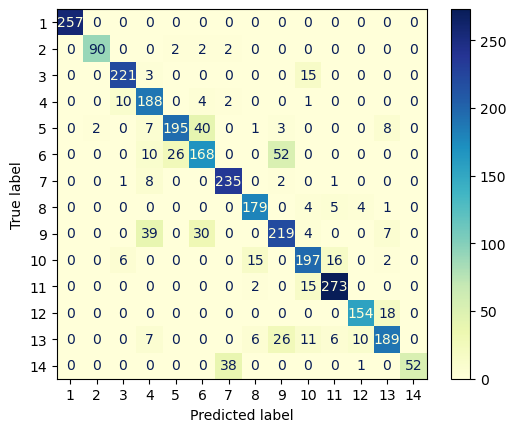

In [87]:
cmap_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', \
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',\
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=clf.classes_)
disp.plot(cmap=cmap_list[14])
plt.show()

In [88]:
print(f'\nOverall Accuracy: {colored(ov_acc, "green")}\n\n\u03BA = {colored(kappa, "green")}\n')


Overall Accuracy: 0.8463777490297542

κ = 0.833495563774022



$\newline$
$\newline$
<a name=''>$\bf{\text{Classification Map}}$</a>
$\newline$
$\newline$

In [118]:
X_3d = pymat.read_mat(path_str + data_file_name)['Botswana']
y_2d = pymat.read_mat(path_str + gt_file_name)['Botswana_gt']

In [119]:
X_test = X_3d.reshape((X_3d.shape[0]*X_3d.shape[1], 145))
y_test = y_2d.ravel()

In [120]:
y_pred = clf.predict(X_test)

In [124]:
y_pred[y_test == 0] = 0

In [125]:
y_pred_plot = y_pred.reshape((1476, 256))
y_test_plot = y_test.reshape((1476, 256))

In [126]:
y_test_plot.dtype

dtype('uint8')

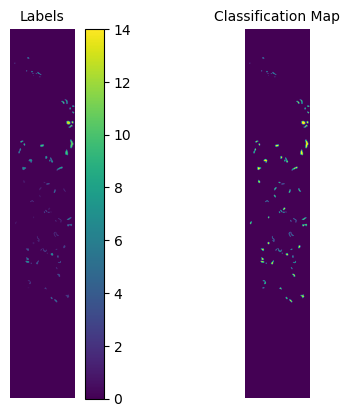

In [132]:
plt.figure(1)
plt.subplot(1, 2, 1), plt.imshow(y_test_plot), plt.axis('off'), plt.title('Labels', fontsize=10)
plt.colorbar()
plt.subplot(1, 2, 2), plt.imshow(y_pred_plot), plt.axis('off'), plt.title('Classification Map', fontsize=10)
plt.show()

$\newline$
$\newline$
<a name=''>$\bf{\text{End Classification Map}}$</a>
$\newline$
$\newline$

$\newline$
$\newline$
<a name=''>$\bf{\text{Classification Map for Test Data}}$</a>
$\newline$
$\newline$

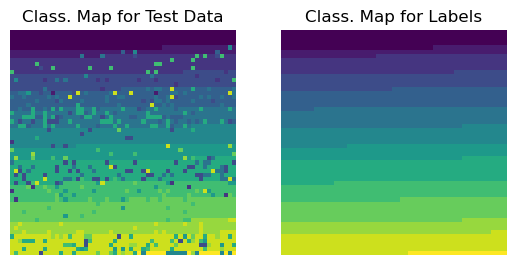

In [90]:
plt.figure(1)
plt.subplot(1, 2, 1), plt.imshow(selected_y_pred_reshaped), \
plt.axis('off'), plt.title('Class. Map for Test Data')

plt.subplot(1, 2, 2), plt.imshow(selected_y_test_reshaped), \
plt.axis('off'), plt.title('Class. Map for Labels')
plt.show()

$\newline$
$\newline$
<a name=''>$\bf{\text{End of Classification Map for Test Data}}$</a>
$\newline$
$\newline$

In [91]:
my_ov_acc = len(y_pred[y_pred == y_test]) / len(y_pred)
print(f'\n{colored("Ov. Accuracy:", "green")} {my_ov_acc: 0.3f}\n')


Ov. Accuracy:  0.846



In [92]:
AA = df_result1['Accuracy'].mean()
AA

0.8423304772142849

In [93]:
gt = gt_without_BG.flatten()

In [94]:
num_class_1 = len(data_without_BG[gt == 1])
num_class_1

270

In [95]:
num_class_14 = len(data_without_BG[gt == 14])
num_class_14

95